In [1]:
"""
Plot the predicted prevalences against the observed ones for the four simple models
that only contain the ipsilateral LNLs II and III.
"""
from itertools import cycle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import h5py

import lyscripts.plot.histograms as lyhist

# Define some parameters for plots

In [2]:
# define USZ colors
COLORS = {
    "green": '#00afa5',
    "orange": '#f17900',
    "blue": '#005ea8',
    "red": '#ae0060',
    # "gray": '#c5d5db',
}
COLOR_CYCLE = cycle(COLORS.values())

HIST_KWARGS = {
    "density": True,
    "histtype": "stepfilled",
    "alpha": 0.7,
}

In [3]:
def get_datasets(file_name):
    dataset_names = []

    def find_datasets(name, obj):
        # If the object is a dataset, add its name to the list
        if isinstance(obj, h5py.Dataset):
            dataset_names.append(name)

    # Open the HDF5 file
    with h5py.File(file_name, 'r') as file:
        # Recursively search for datasets
        file.visititems(find_datasets)

    return dataset_names


In [4]:
data_root = '../graph_results/prevalences'

## Prevalences Base Graph

In [6]:
#  Usage
file_name = f'{data_root}/base_A_prevalences.hdf5'
datasets = get_datasets(file_name)
scenarios = set([dataset.split('/')[0] for dataset in datasets])
scenarios

{'IIInotII', 'IIIoverall', 'IInotIII', 'IIoverall', 'IVnotIII', 'IVoverall'}

In [8]:
BINS = np.linspace(0., 55., 200)
HIST_KWARGS["bins"] = BINS
SCENARIO_DICT = {
    "IIoverall": "LNL II overall involvement",
    "IIIoverall": "LNL III overall involvement",
    "IVoverall": "LNL IV overall involvement",
    'IInotIII': 'II but not III involved',
    'IIInotII': 'III but not II involved',
    'IVnotIII': 'IV but not III involved',
}


In [11]:
# Specify models and respective data source locations
MODELS = {}
for tag in ["A", "B", "C"]:
    MODELS[tag] = Path(f"base_{tag}_prevalences.hdf5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'base_A_prevalences.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

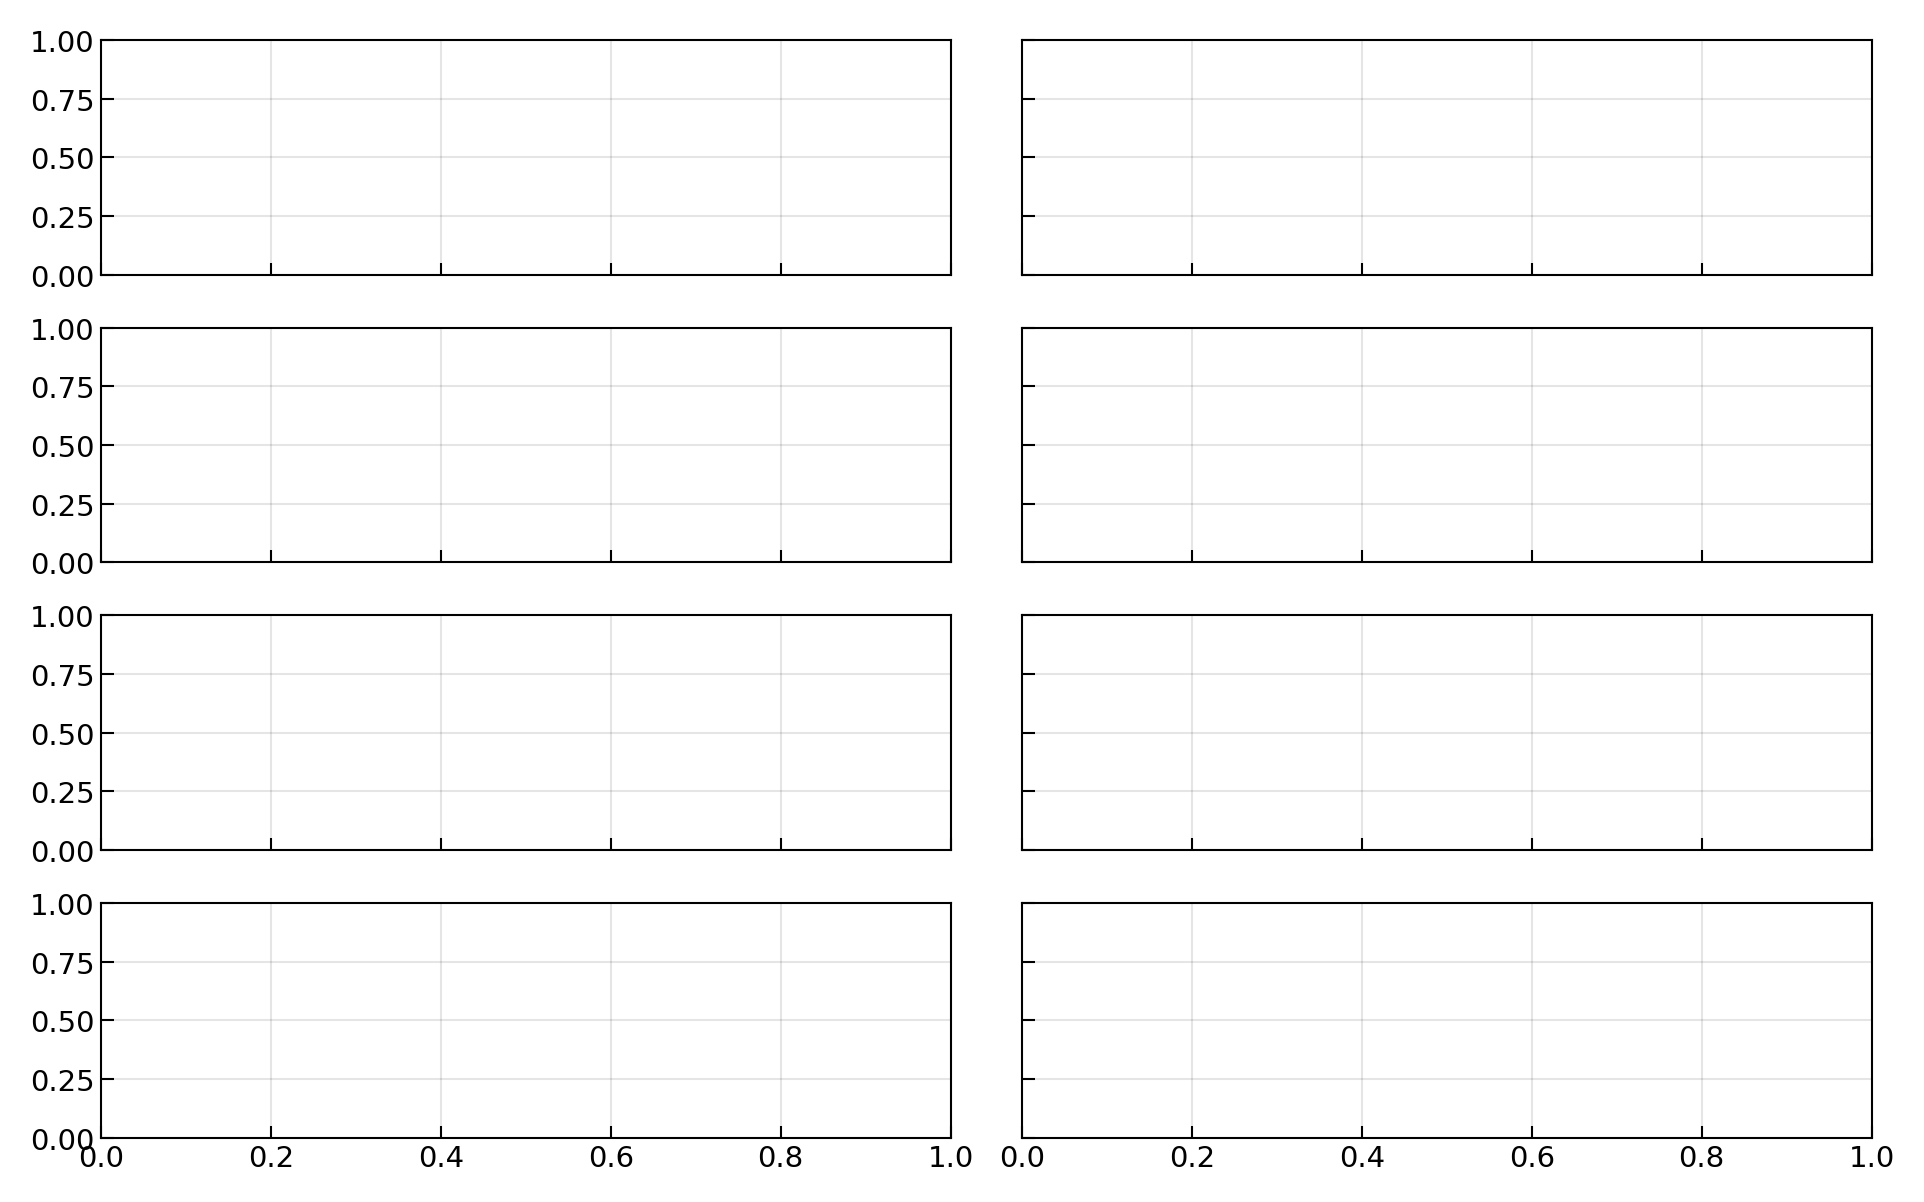

In [12]:
plt.style.use(Path("../../.mplstyle"))

fig, ax = plt.subplot_mosaic([
    ["nocon/early"  , "nocon/late"  ],
    ["IItoIII/early", "IItoIII/late"],
    ["IIItoII/early", "IIItoII/late"],
    ["both/early"   , "both/late"   ],
],
    sharex=True, sharey=True,
    figsize=lyhist.get_size(width="full"),
)

for i, (modelname, filepath) in enumerate(MODELS.items()):
    with h5py.File(name=filepath, mode="r") as h5_file:
        for scenario in ["healthy", "II", "III", "both"]:
            color = next(COLOR_CYCLE)
            for stage in ["early", "late"]:
                axname = f"{modelname}/{stage}"
                scenario_name = SCENARIO_DICT[scenario]

                dataset = h5_file[f"{scenario}/{stage}"]
                values = 100. * dataset[:]
                a = dataset.attrs.get("num_match", np.nan)
                n = dataset.attrs.get("num_total", np.nan)
                posterior = sp.stats.beta.pdf(BINS / 100., a+1, n-a+1) / 100.
                max_idx = np.argmax(posterior)
                max_x = BINS[max_idx]
                max_y = posterior[max_idx]

                ax[axname].hist(
                    values,
                    label=scenario_name,
                    color=color,
                    **HIST_KWARGS,
                )
                ax[axname].plot(
                    BINS, posterior,
                    label=f"{int(a)} / {int(n)}",
                    color=color,
                )

                ax[axname].set_ylim(0., 0.59)
                if stage == "early":
                    ax[axname].set_ylabel(f"graph no. {i+1}")

ax["nocon/early"].legend(fontsize=6.0, ncol=2)
ax["nocon/late"].legend(fontsize=6.0, ncol=2)

ax["both/early"].set_xlim(left=BINS[0], right=BINS[-1])
ax["both/late"].set_xlim(left=BINS[0], right=BINS[-1])
ax["both/early"].set_xlabel("early T-category prevalences [%]")
ax["both/late"].set_xlabel("late T-category prevalences [%]")

plt.savefig("simple-prevalences.svg")
